In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import scipy
import seaborn as sns
import sklearn
import pysindy as ps 
from sklearn.linear_model import Lasso
from tools import get_positive_contributions, compute_entropy, print_equations
from data_func import plot_clustered_kuramoto, generate_kuramoto_cluster_data_sin_cos

pipline操作流程：

1.生成数据：a 单起始点时间序列；b 多起始点时间序列

可选步骤：时间序列降采样

2.选择合适的library做观测

3.选择合适的optimizer做拟合：a 离散的迭代方程；b 连续的微分方程

4.计算score，多步预测效果看一下

5.提取系数矩阵，进行svd分解，得到奇异值谱和左奇异向量

6.观察奇异值谱截断，计算因果涌现程度，绘制多尺度contribution，计算EC

7.根据奇异向量和谱截断，输出粗粒化函数表达式

8.绘制宏观演化的时间序列，给出宏观动力学方程

可选的分析案例：

1.SIR：原始的SIR动力学；带观测噪音的四维微观数据

2.kuramoto模型

3.洛伦兹动力学

4.耦合Rulkov映射

# 数据生成

In [2]:
def sir_model_normalized(y, t, beta, gamma):
    """
    归一化SIR模型的微分方程。
    y: 一个包含s, i, r比例的列表或数组
    t: 时间点
    beta: 传染率
    gamma: 康复率
    """
    s, i, r = y
    ds_dt = -beta * s * i
    di_dt = beta * s * i - gamma * i
    dr_dt = gamma * i
    return [ds_dt, di_dt, dr_dt]

In [3]:
def gen_sir_data(
    initial_infected_ratio=0.5,
    initial_recovered_ratio=0.0,
    beta=0.3,
    gamma=0.05,
    total_days=200,
    dt=0.01,
    noise_mean=0.0,
    noise_std=0.001,
    random_seed=None
):
    """
    生成带噪声的SIR模型数据
    
    参数:
    --------
    initial_infected_ratio : float初始感染比例
    initial_recovered_ratio : float初始康复比例
    beta : float传染率
    gamma : float康复率
    total_days : int模拟总天数
    dt : int间距
    noise_mean : float高斯噪声均值
    noise_std : float高斯噪声标准差
    random_seed : int or None随机种子，用于复现结果
    
    返回:
    --------
    data : np.ndarray包含噪声的SIR数据，列顺序：s, i,r
    t : np.ndarray时间数组
    """
    # 设置随机种子
    if random_seed is not None:
        np.random.seed(random_seed)
    
    # 计算初始易感比例
    initial_susceptible_ratio = 1.0 - initial_infected_ratio - initial_recovered_ratio
    y0 = [initial_susceptible_ratio, initial_infected_ratio, initial_recovered_ratio]
    
    # 生成时间点
    t = np.arange(0, total_days, dt)
    
    # 求解SIR模型
    solution = odeint(sir_model_normalized, y0, t, args=(beta, gamma))
    
    # 构造无噪声数据（重复s和i列）
    s_col = solution[:, 0, np.newaxis]
    i_col = solution[:, 1, np.newaxis]
    r_col = solution[:, 2, np.newaxis]
    data_noiseless = np.hstack([s_col, i_col, r_col])
    
    # 添加高斯噪声
    noise = noise_mean + np.random.randn(*data_noiseless.shape) * noise_std
    x = data_noiseless + noise
    
    return x, t

In [4]:
def plot_sir_results(x, t, figsize=(12, 4), title_prefix="SIR Model"):
    if isinstance(x, np.ndarray) and isinstance(t, np.ndarray):
        x = [x]
        t = [t]
    # ========== 初始化画布 ==========
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # ========== 多序列样式配置（自动渐变颜色+透明度） ==========
    n_sequences = len(x)
    # 生成渐变颜色（基于序列数量自动分配）
    cmap = plt.cm.viridis  # 美观的渐变色谱（蓝→绿→黄→红）
    colors = cmap(np.linspace(0, 1, n_sequences))
    # 透明度梯度（避免多序列重叠过密）
    alphas = np.linspace(0.2, 0.8, n_sequences)

    # ========== 遍历绘图 ==========
    for idx in range(n_sequences):
        data = x[idx]
        t_seq = t[idx]
        color = colors[idx]
        alpha = alphas[idx]
        
        # 时间序列图：单序列展示s/i/r，多序列只展示i（带渐变颜色+透明度）
        if n_sequences == 1:  # 单序列：保留原始样式
            ax1.plot(t_seq, data[:,0], color='blue', label='Susceptible (s)', linewidth=1.5)
            ax1.plot(t_seq, data[:,1], color='red', label='Infected (i)', linewidth=1.5)
            ax1.plot(t_seq, 1-data[:,0]-data[:,1], color='green', label='Recovered (r)', linewidth=1.5)
            ax1.legend()  # 单序列显示图例
        else:  # 多序列：渐变颜色+透明度，仅展示i列
            ax1.plot(t_seq, data[:,1], color=color, alpha=alpha, linewidth=0.5)
        
        # 相平面图：单/多序列差异化样式
        ax2.plot(
            data[:,0], data[:,1], 
            color=color, alpha=alpha,
            linewidth=1.5 if n_sequences == 1 else 0.5
        )

    # ========== 统一图表配置 ==========
    # 时间序列图
    ax1.set_xlabel('Time (days)')
    ax1.set_ylabel('Proportion')
    ax1.set_title(f'{title_prefix} - Time Series')
    ax1.grid(alpha=0.3)
    
    # 相平面图（多序列添加颜色条，直观区分轨迹）
    ax2.set_xlabel('Susceptible (s)')
    ax2.set_ylabel('Infected (i)')
    ax2.set_title(f'{title_prefix} - Phase Plane')
    ax2.grid(alpha=0.3)
    
    # 多序列添加颜色条（无需额外参数，自动生成）
    if n_sequences > 1:
        sm = mpl.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(0, n_sequences-1))
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax2, shrink=0.8)
        cbar.set_label('Sequence Index', fontsize=8)

    plt.tight_layout()
    plt.show()

In [5]:
initial_infected_ratio=0.5
initial_recovered_ratio=0.0
beta=0.2
gamma=0.05
total_days=50
dt=0.01
noise_mean=0.0
noise_std=0.00
random_seed=None

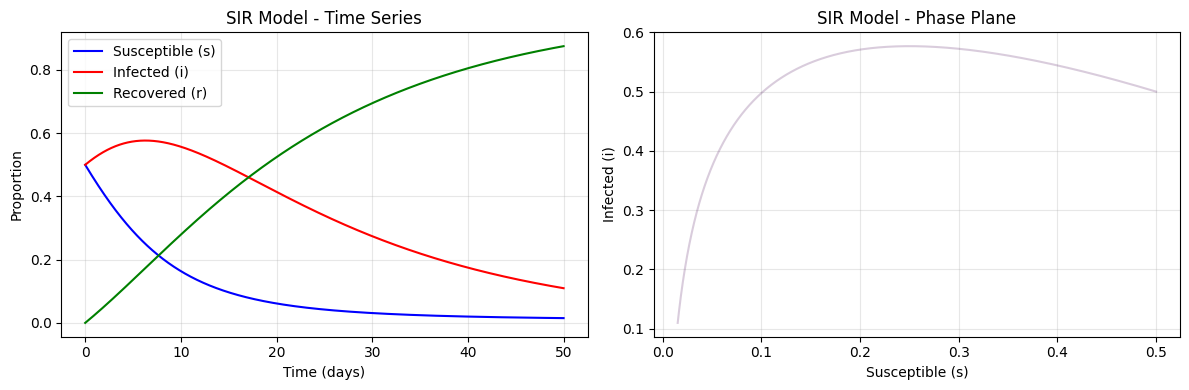

In [6]:
# 单时间序列采样
x_train, t_train = gen_sir_data(initial_infected_ratio=initial_infected_ratio,
    initial_recovered_ratio=initial_recovered_ratio,
    beta=beta,
    gamma=gamma,
    total_days=total_days,
    dt=dt,
    noise_mean=noise_mean,
    noise_std=noise_std,
    random_seed=random_seed
)
x_data = x_train
t_list = t_train

plot_sir_results(x_data,t_list)

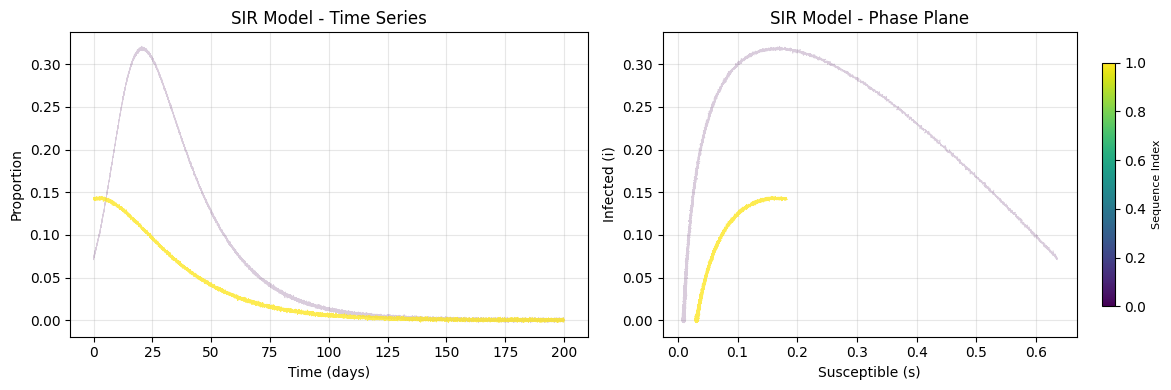

In [11]:
# 多时间序列采样
batch_size = 2  # 生成数量可自定义

# 初始化两个空列表，存储合法的初始比例
initial_infected_ratios = []
initial_recovered_ratios = []

# 循环生成满足 s+i < 1 的比例对
while len(initial_infected_ratios) < batch_size:
    # 随机生成初始感染比例（范围可自定义，比如0.01~0.8）
    inf_ratio = np.random.uniform(0.01, 0.99)
    # 随机生成初始康复比例（范围可自定义，比如0.0~0.2）
    rec_ratio = np.random.uniform(0.01, 0.99)
    
    # 核心约束：感染+康复 < 1，确保易感比例为正
    if inf_ratio + rec_ratio < 1.0:
        initial_infected_ratios.append(inf_ratio)
        initial_recovered_ratios.append(rec_ratio)

t_list = []
x_data = []
for idx in range(batch_size):
    x_train, t_train = gen_sir_data(
        initial_infected_ratio=initial_infected_ratios[idx],  # 取第idx个感染比例
        initial_recovered_ratio=initial_recovered_ratios[idx], # 取第idx个康复比例
        beta=beta,
        gamma=gamma,
        total_days=total_days,
        dt=dt,
        noise_mean=noise_mean,
        noise_std=noise_std,
        random_seed=42+idx
    )
    x_data.append(x_train)
    t_list.append(t_train)
plot_sir_results(x_data,t_list)

# 选择library

In [7]:
# 候选的观测函数
ide = ps.IdentityLibrary()
fourier = ps.FourierLibrary(n_frequencies=1)
ode_lib = ps.PolynomialLibrary(degree=1,include_bias=True)
library_functions = [
    lambda x: x,
    lambda x: np.sin(x),
    lambda x: np.cos(x),
]
custom_library = ps.CustomLibrary(library_functions=library_functions)

# 选定观测函数
library = ide

# 进行lift
library.fit(x_data)
x_data_lift = library.transform(x_data)
names = library.get_feature_names()

# 单时间序列
print(x_data.shape)
print(x_data_lift.shape)
# 多时间序列
#print(x_data_lift[0].shape)
# 检查观测函数变量名
print(names)

(5000, 3)
(5000, 3)
['x0', 'x1', 'x2']


# 进行拟合

In [8]:
# 离散的迭代方程 or 连续的微分方程
#discrete_time=False
discrete_time=True

# 候选拟合器
sr3_optimizer = ps.SR3(reg_weight_lam=0.2, regularizer="l1")
lasso_optimizer = Lasso(alpha=0.01, max_iter=2000, fit_intercept=False)

optimizer = lasso_optimizer

# 进行拟合
model = ps.SINDy(feature_library=ide, optimizer=optimizer, discrete_time=discrete_time)
model.fit(x_data_lift, t=dt, feature_names=names)
model.print()

(x0)[k+1] = 0.061 x0[k] + 0.248 x1[k] + -0.008 x2[k]
(x1)[k+1] = 0.931 x1[k] + 0.001 x2[k]
(x2)[k+1] = 0.973 x2[k]


In [9]:
# 计算score
model.score(x_data_lift, t=dt)

0.822216997189698

# 多步预测

In [10]:
# 单时间序列
init_data = x_data_lift[0,:]
# 多时间序列
#init_data = x_data_lift[0][0,:]

if discrete_time:
    X_data_predicted = model.simulate(init_data,len(t_list)-1)
else:
    X_data_predicted = model.simulate(init_data,t_list) 

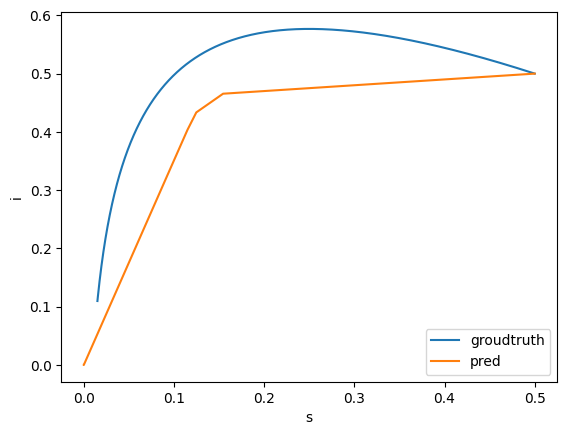

In [12]:
plt.figure()
plt.plot(x_data_lift[:, 0],x_data_lift[:, 1],label='groudtruth')
plt.plot(X_data_predicted[:, 0],X_data_predicted[:, 1],label='pred')
plt.xlabel('s')
plt.ylabel('i')
plt.legend()
plt.show()

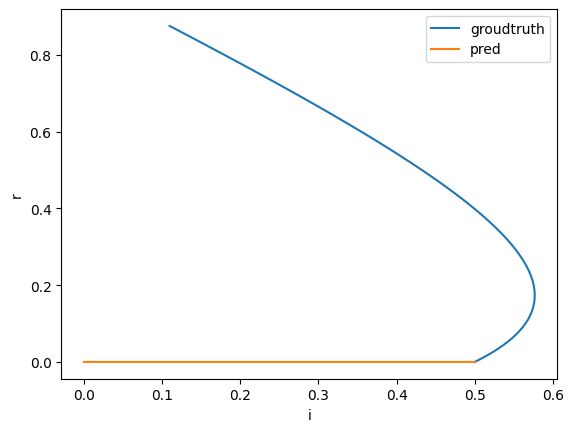

In [13]:
plt.figure()
plt.plot(x_data_lift[:, 1],x_data_lift[:, 2],label='groudtruth')
plt.plot(X_data_predicted[:, 1],X_data_predicted[:, 2],label='pred')
plt.xlabel('i')
plt.ylabel('r')
plt.legend()
plt.show()

C:\Users\Administrator.DESKTOP-BFUOLPM\AppData\Local\Temp\ipykernel_13252\2159156584.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


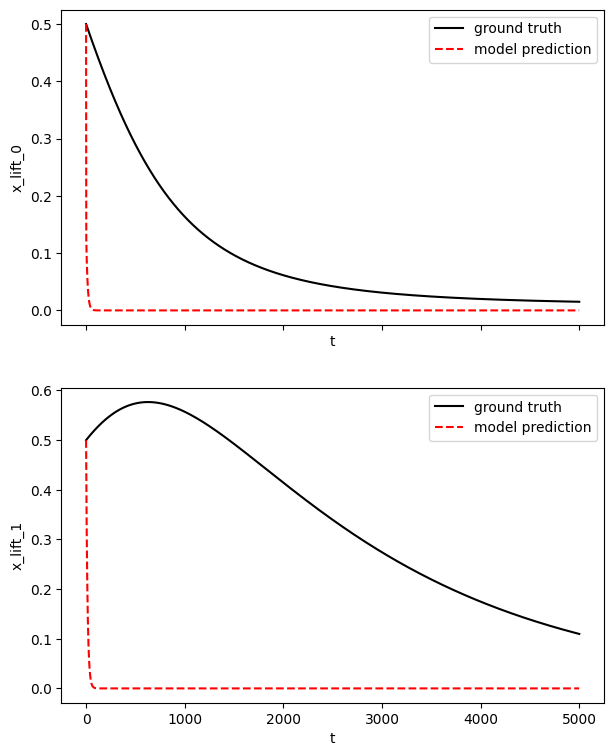

In [14]:
# 只看部分维度的多步预测
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(7, 9))
for i in range(2):
    axs[i].plot(x_data_lift[:, i], "k", label="ground truth")
    axs[i].plot(X_data_predicted[:, i], "r--", label="model prediction")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=r"x_lift_{}".format(i))
fig.show()

# svd分解

(3, 3)


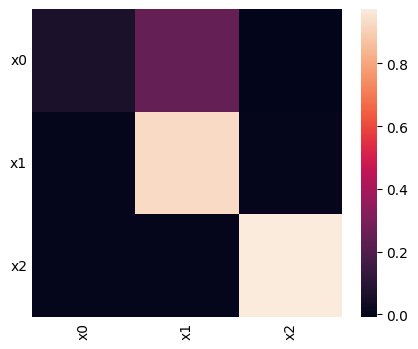

In [15]:
# 提取和处理系数矩阵
A = model.coefficients()
print(A.shape)
if discrete_time==False:
    A = scipy.linalg.expm(A)

# 只设置参数，不自动显示全部
plt.figure(figsize=(5, 4)) # 把画布搞大一点
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(A, xticklabels=names, yticklabels=names)
# 旋转横轴标签，避免重叠
plt.xticks(rotation=90)  # 旋转90度
plt.yticks(rotation=0)   # 纵轴保持水平
plt.show()

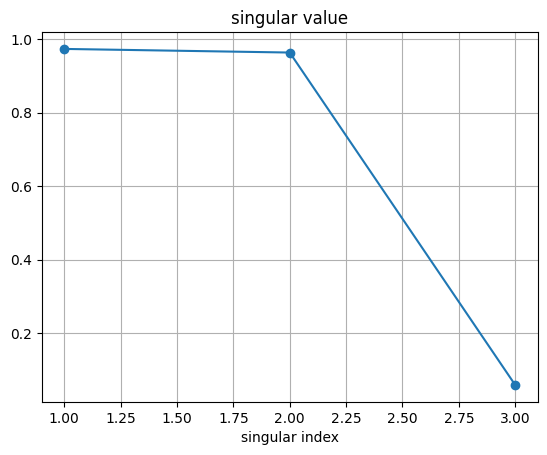

[0.9733536  0.96350889 0.05918724]


In [16]:
# SVD
U,S,V = np.linalg.svd(A)
plt.figure()
plt.plot(range(1,len(S)+1), S, marker='o')
plt.grid(True)
plt.xlabel('singular index')
plt.title('singular value')
plt.show()
print(S[:6])

In [17]:
# 选取截断
rank = 2
S_macro = S[:rank]
delt_gamma = sum(S_macro) / rank - sum(S) / len(S)
print(delt_gamma)

0.30308133404482773


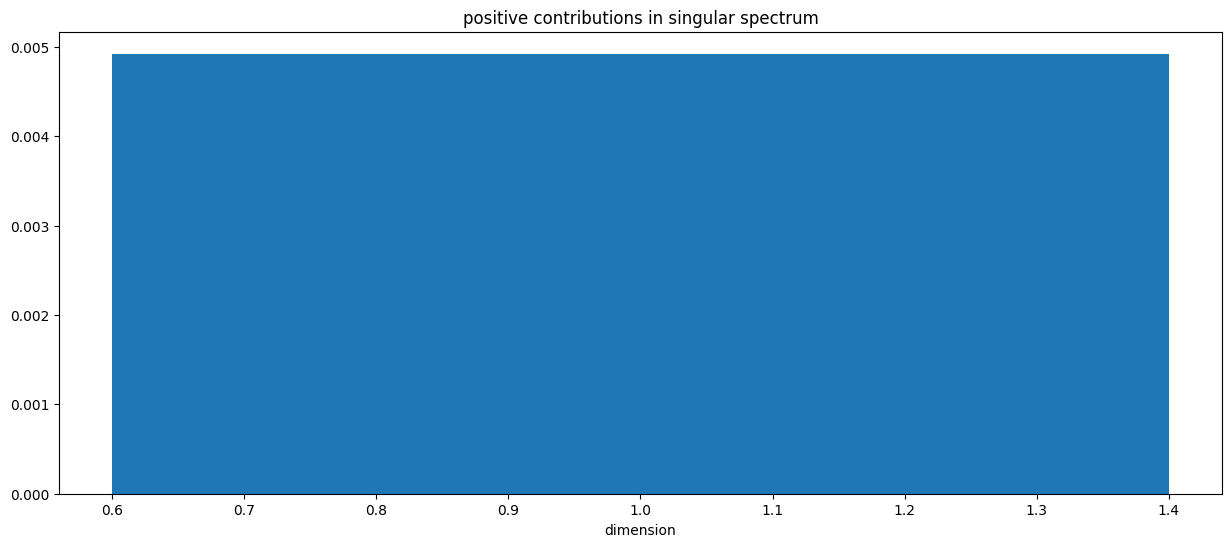

In [18]:
# 多尺度因果力分布
diff = get_positive_contributions(S)
plt.figure(figsize=(15, 6))
plt.bar(range(1,len(diff)+1), diff) 
plt.xlabel('dimension')
plt.title('positive contributions in singular spectrum')
plt.show()

In [19]:
# 计算EC
print(compute_entropy(diff))

0.0


# 输出粗粒化表达式

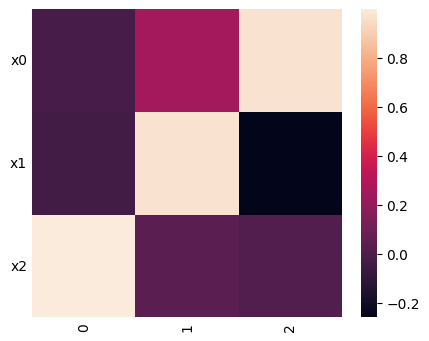

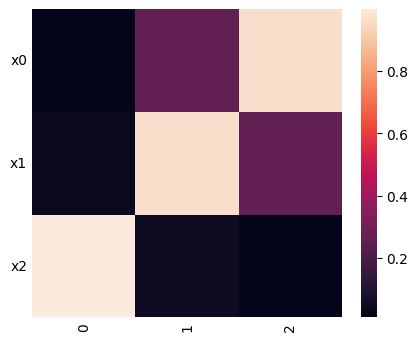

In [20]:
# 绘制奇异向量
U_abs = np.abs(U)

plt.figure(figsize=(5, 4)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(U, yticklabels=names)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()


plt.figure(figsize=(5, 4)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(U_abs, yticklabels=names)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show() 

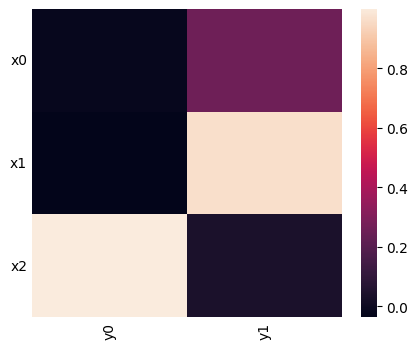

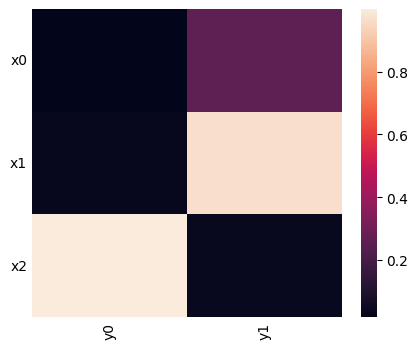

In [21]:
# 粗粒化函数系数
macro_name = [f'y{i}' for i in range(rank)]
coarse_grain_coff = U[:,:rank]

plt.figure(figsize=(5, 4)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(coarse_grain_coff, yticklabels=names, xticklabels=macro_name)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()


plt.figure(figsize=(5, 4)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(np.abs(coarse_grain_coff), yticklabels=names, xticklabels=macro_name)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()

In [22]:
# 输出粗粒化函数表达式
print_equations(coarse_grain_coff, names, macro_name)

y0 = -0.0185 * x0 - 0.0362 * x1 + 0.9992 * x2
------------------------------
y1 = 0.2574 * x0 + 0.9655 * x1 + 0.0397 * x2
------------------------------


# 描述宏观演化

C:\Users\Administrator.DESKTOP-BFUOLPM\AppData\Local\Temp\ipykernel_13252\580934310.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


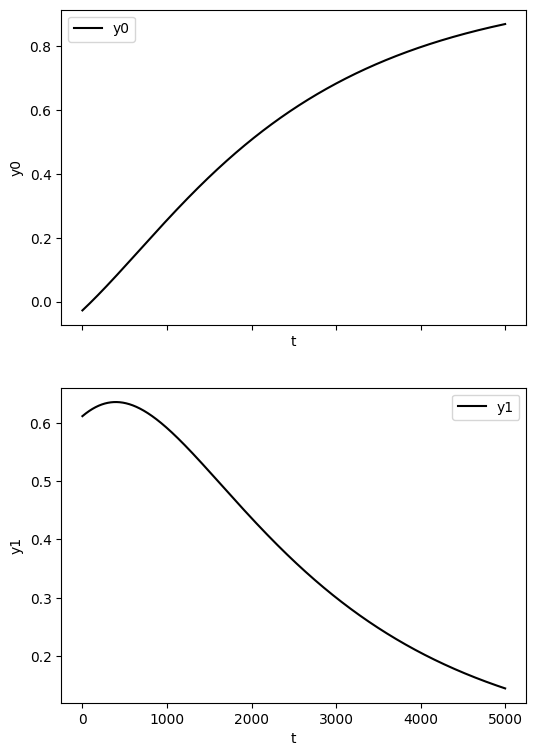

In [23]:
macro_data = x_data_lift @ coarse_grain_coff
macro_dim = macro_data.shape[1]

fig, axs = plt.subplots(macro_dim, 1, sharex=True, figsize=(int(3*macro_dim), 9))
for i in range(macro_dim):
    axs[i].plot(macro_data[:, i], "k", label=f"y{i}")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=f"y{i}")
fig.show()

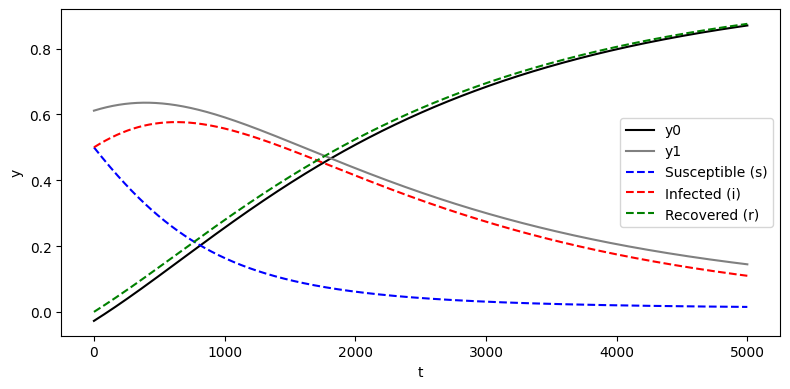

In [26]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(macro_data[:,0], color='k', label='y0')  
ax.plot(macro_data[:,1], color='grey', label='y1')  
ax.plot(x_data[:,0], '--',color='blue', label='Susceptible (s)')
ax.plot(x_data[:,1], '--',color='red', label='Infected (i)')
ax.plot(x_data[:,2], '--',color='green', label='Recovered (r)')
ax.legend()
ax.set(xlabel='t', ylabel='y')
fig.tight_layout()
plt.show()

In [25]:
# 给出宏观动力学方程
A_macro = coarse_grain_coff.T @ A @ coarse_grain_coff
macro_name_k = [i+'[k]' for i in macro_name]
macro_name_next = [i+'[k+1]' for i in macro_name]
print_equations(A_macro, macro_name_k, macro_name_next)

y0[k+1] = 0.9732 * y0[k] + 0.0027 * y1[k]
------------------------------
y1[k+1] = 0.0014 * y0[k] + 0.9350 * y1[k]
------------------------------
